# Fleshed out example
NOTE: This notebook is pretty rough. It will development  change during development of the code..

#### Imports

In [4]:
# Useful for plottimg
from matplotlib import pyplot as plt

# Useful for calculations
import numpy as np

# Useful for getting lists of files, etc
import os
import glob

# I use *pickle* to load some external "pickled" datasets. Not necessary for anything else. 
import pickle
# Also use xarray to load some external data
import xarray as xr

# I use *mpl.dates* to enter some dates. Not necessary for anything else. 
from matplotlib import dates
from matplotlib.dates import date2num, num2date

# Useful in development..
import importlib

### Find modules and  files we will work with

In [5]:
# Load the modules

# Changing directories because we need to be in the directory below the functions
# (may make this a bit neater later..)
os.chdir('/home/oyvindl/work/code/git_public/sigpyproc/examples/')
os.chdir('../')
from sigpyproc import sig_load, sig_append, sig_calc, sig_draft
from sigpyproc import sig_vel, sig_toolbox, sig_append
os.chdir('examples/')

In [6]:
# Make a list of the .mat files we want to load 
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

## Load the data 

##### Load from matfiles to a neatly xarray Dataset 

- Wraps from a simgle time dimension to *(TIME, SAMPLE)*
- Concatenates the many .mat files to a single file
- Various formatting stuff
- Calculate tilt
- Estimates sea ice presence from FOM (and adds "sea ice concentration" fields)

Specifying lat/lon here - that can also be done later

This step takes a while (a minute or so?).

Throws some errors that I haven't investigated (don't seem to matter but I don't want to suppress them, until I'm sure what they are)

In [7]:
DX = sig_load.matfiles_to_dataset(flist[:], lat = 79.589, lon = 28.097)

1870992 time points, 38979 ensembles. Sample per ensemble: 48
Done. Run sig_funcs.overview() to print some additional details.


##### Have a quick look at the data 

We can look at the file interactively by just typing "DX".

We can also run *sig_load.overview(DX)* for some very basic statistics.

We can also run *sig_toolbox.histogram(DX, [variable name])* to look at the distribution of a variable 

In [9]:
sig_load.overview(DX)


TIME RANGE:
06 Oct 2018 12:00  -->  16 Nov 2019 12:30  (406.0 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure: 20.6 dbar (0.5 dbar)  - with fixed atm offset 9.500 dbar.

SIZE:
Total 1870992 time points.
Split into 38979 ensembles with 48 sample per ensemble.
Ocean velocity bins: 16.


## Append some external datasets

We can append external data to *DX* using the *sig_append* module. The functions in the module interpolates external data onto the *TIME* grid.

The function *sig_append.add_to_sigdata* is general and can be used to append whatever can be of use.

There are specified functions for appending specific things that are used in subsequent processing: 

- *sig_append.append_atm_pres*: Append **sea level pressure** (used for depth correction)
- *sig_append.append_ctd*: Append **S, T, P from CTD sensor** (used for density and sound speed corrections)
- *sig_append.set_lat, set_lon*: Add (single-value) **lat/lon** (if it wasn't done in the initial loading step)
- *sig_append.append_magdec*: Add **magnetic declination** (used for correction of velocity directions). 

#### Append atmospheric pressure from CARRA atmospheric reanalysis 

Load a dataset containing sea level pressure.

(I have previously collected these data from CARRA reanalysis).

Note that these should be provided in units of **decibars**.

In [10]:
with open('../testing/development/CARRA_MSL_M1_temp.p', 'rb') as f:
    dmsl = pickle.load(f)

In [11]:
carra_m1 = xr.open_dataset('/media/oyvindl/ratatosk/data/carra/selected_points/carra_18_22_M1.nc')

In [12]:
DX_no_msl = DX.copy()

In [13]:
# Append to the dataset
DX = sig_append.append_atm_pres(DX, carra_m1.msl.data*1e-4, date2num(carra_m1.time))

We now have a *p_atmo* field in *DX*:
Make a quick plot to check that our interpolation worked:

(17832.0, 17842.0)

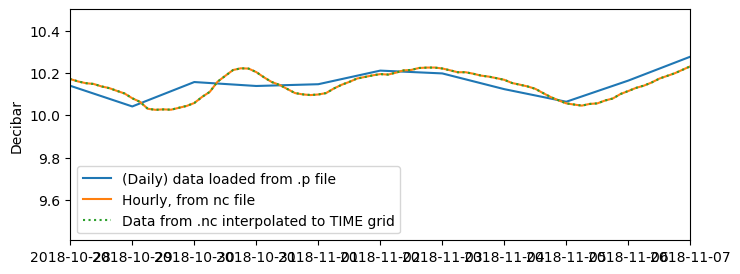

In [14]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.plot_date(dmsl.time, dmsl.MSL, '-', label = '(Daily) data loaded from .p file')
ax.plot(carra_m1.time, carra_m1.msl*1e-4, '-', label = 'Hourly, from nc file')
ax.plot(DX.TIME, DX.p_atmo, ':', label = 'Data from .nc interpolated to TIME grid')

ax.legend()
ax.set_ylabel('Decibar')
ax.set_xlim(dmsl.time[300], dmsl.time[310])

#### Append CTD data
Next, we add data from a CTD sensor that was mounted rigth below the Signature. We will use it to improve our sound speed and density estimates - it is also interesting to includefor analysis purposes!

In [15]:
# Load data (which I have prepared in advance)

with open('../testing/development/CARRA_CTD_M1_1_temp.p', 'rb') as f:
    dctd = pickle.load(f)
    
# Chop away nan ends..
ctd_sl = slice(3, -3)
for key in dctd.keys():
    dctd[key] = dctd[key][ctd_sl]

In [16]:
# Append to the dataset
# (Specifying serial number and description is optional!)
DX = sig_append.append_ctd(DX, dctd.TEMP, dctd.SP, dctd.pres, dctd.time,
             instr_SN = '11111', 
           instr_desc = 'RBR Concerto CTD sensor mounted right below the Signature' )

The *append_ctd* function read T/S/p variables. These were converted to TEOS-10 using the *gsw* module. It also calculated sound speed and density.

We therefore have some new fields in DX, all with the suffix *_CTD*: *SA_CTD, CT_CTD, sound_speed_CTD..*. The descriptions we prescribed, as well as other metadata such as units and full name, should be available in the variable attributes, e.g.:

#### Append magnetic declination

In this case, we know that the declination only changes by <0.5 degrees over the deployment. For now, we are happy using a linear interpolation based two values we found for two points in time (from the EMM, extracted using this online calculator: https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm)

In [17]:
magdec_fn = '/home/oyvindl/work/data/magdec/igrfwmm_pickles/igrfwmm_m1.p'
with open(magdec_fn, 'rb') as f:
    magdec = pickle.load(f)

In [18]:
# Append to DX (the attributes are not necessary - 
# but it's a good idea to keep track of this sort 
# of stuff in the file metadata!)

DX = sig_append.append_magdec(DX, magdec['magdec'], magdec['time'], 
         attrs = {'note':('Magdec interpolated between extracted from EMM, '
              'extracted using this online calculator: '
              'https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm')})

In [19]:
# Inspect magdec in DX
DX.magdec

<xarray.DataArray 'magdec' (TIME: 38979)>
array([19.18178401, 19.18179678, 19.18180955, ..., 19.68157211,
       19.68158497, 19.68159783])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    long_name:  Magnetic declination
    units:      degrees
    note:       Magdec interpolated between extracted from EMM, extracted usi...

Note that the append_magdec *extrapolates*. Let's look at the actual values: 

Text(0, 0.5, 'Degrees')

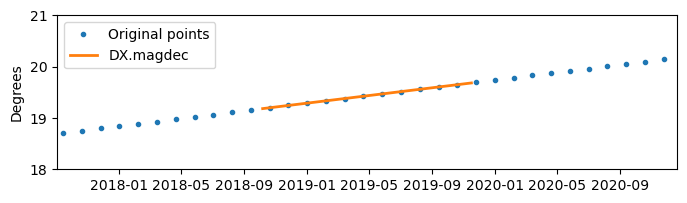

In [20]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot_date(magdec['time'], magdec['magdec'], '.', label = 'Original points')
ax.plot(DX.TIME, DX.magdec, label = 'DX.magdec', lw =2)
ax.legend()
ax.set_xlim(num2date(DX.TIME[0] - 400), num2date(DX.TIME[-1] + 400))
ax.set_ylim(18, 21)

ax.set_ylabel('Degrees')

#### Add AMSR2 SIC

Adding SIC is not necessary for anything. But it is an example of a information that can be useful to include for analysis - remote sensing SIC is also useful for comparing the SIC we have computed from in-situ data! 

In [21]:
# Load previously extracted data
sic = xr.open_dataset('/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc')
sic_data = sic.SIC_m1
sic_time = sic.time+0.5 # We add half a day because the daily time stamp is at 00:00

In [22]:
# 'SIC_AMSR2' specified what we want this variable to be called. A name is mandatory,
# "attrs" specifies attributes/metedata info. Not necessary but useful!
DX = sig_append.add_to_sigdata(DX, sic_data, sic_time, 'SIC_AMSR2', 
               attrs = {'long_name':'AMSR2 UoB sea ice concentration',
        'description':'SIC extracted from the nearest grid point.',
        'sourcefile':'/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc'})

##### Quick look and comparison with "in situ SIC" 
In the *sig_load.matfiles_to_dataset* call in the beginning, we calculated ice presence uring the *FOM* metric, and estimated "SIC" based on this. 

Below we do a quick comparison with the remote sensing SIC that we just added.

Note: We use the function *sig_calc.daily_median* to calculate daily medians

In [ ]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(DX.TIME, DX.SIC_AMSR2, 'k', zorder = 20, lw = 1, label ='AMSR2 SIC (nearest cell)')
ax.plot(DX.TIME, DX.SIC_FOM, color = 'r', alpha = 0.1)
SIC_FOM_dat, td = sig_calc.daily_average(DX.SIC_FOM, DX.TIME, function = 'mean')
ax.plot(td+0.5, SIC_FOM_dat, color = 'r', alpha = 1, label = 'SIC_FOM (daily)')
SIC_FOM_ALT_dat, td = sig_calc.daily_average(DX.SIC_FOM_ALT, DX.TIME, function = 'mean')
ax.plot_date(td+0.5, SIC_FOM_ALT_dat, '-', color = 'g', alpha = 1, 
             lw = 1, label = 'SIC_FOM_ALT (daily)')
ax.legend()

ax.set_ylabel('Concentration [%]');

-> Looks pretty good!

### Calculate depth
Before we calculate ice drafts and velocities, we want to compute the instrument depth $h$. This is done from a hydrostatic approximation  $$h = \frac{p}{\rho g}$$

Where $p$ is the ocean pressure (*Average_AltimeterPressure*) where we have added back the in-build atmospheric correction, but *subtracted* our the time-varying atmopheric pressure that we added earlier (*p_atmo*).  

$\rho$ is density from CTD (*rho_CTD*) and $g$ is (latitude-dependent) gravitational acceleration calculated using the function *gsw.grav*.

It is possible to calculate depth without atmospheric pressure, in-situ density etc. The function uses everything that is available unless we specify *corr_atmo=False* or *corr_CTD_density=False* in the function call. 

In [24]:
# Doing one calculation withotu the TD densioty correction to see if there is a difference..

DX = sig_calc.dep_from_p(DX, corr_CTD_density=True)

DX0 = DX.copy()
DX0 =sig_calc.dep_from_p(DX0, corr_CTD_density=False)

Continuing using fixed rho. Choose: 
(R): Use rho = 1027 kg m-3, or
(S): Specify fixed rho

Input ("") not recognized.
Enter "R" (fixed rho = 1027) or "S" (specify): r
Continuing with fixed rho = 1027.0 kg m-3


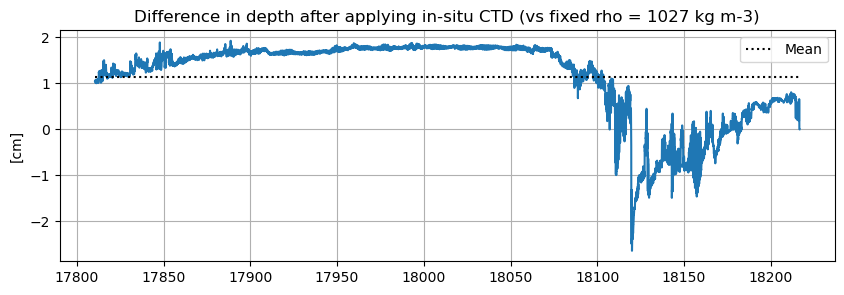

In [25]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(DX.TIME, (DX0.depth- DX.depth).mean(dim='SAMPLE')*1e2, )
ax.set_ylabel('[cm]')
ax.set_title('Difference in depth after applying in-situ CTD (vs fixed rho = 1027 kg m-3)')
meandiff = float((DX0.depth-DX.depth).mean())*1e2
ax.plot([float(DX.TIME[0]), float(DX.TIME[-1])], np.ones(2)*meandiff, ':k', label = 'Mean')
ax.legend(); ax.grid()

As we see, the *note* field details which corrections have been applied. 

**A quick sanity check:** we should have $depth\sim~0$ after the instrument was brought on board

Text(0.5, 1.0, 'Instrument "depth" at the end of deployment')

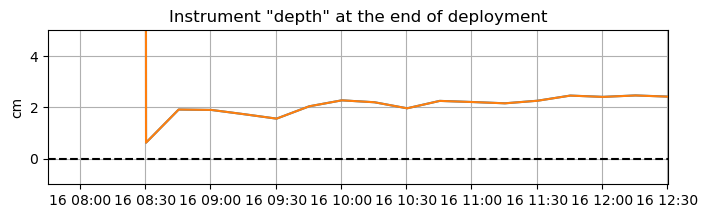

In [26]:
fig, ax = plt.subplots(figsize = (8, 2))
time = num2date(DX.TIME)
ax.plot(time, 1e2*DX.depth.mean(dim = 'SAMPLE'))#, label = 'DX.magdec')
ax.plot(time, 1e2*DX0.depth.mean(dim = 'SAMPLE'), '-')#, label = 'DX.magdec')

ax.set_ylabel('cm')
ax.set_xlim(time[-20], time[-1])
ax.set_ylim(-1, 5)
ax.axhline(0, ls = '--', color = 'k')
ax.grid()
ax.set_title('Instrument "depth" at the end of deployment')

-> Yep, we are about 1 to 3 cm off which **seems pretty good.**

### Chopping away on-ship measurements
We actually don't want to include the measurements taken on deck or after/during deployments. We can easily chop everything using the function *sig_load.chop*:

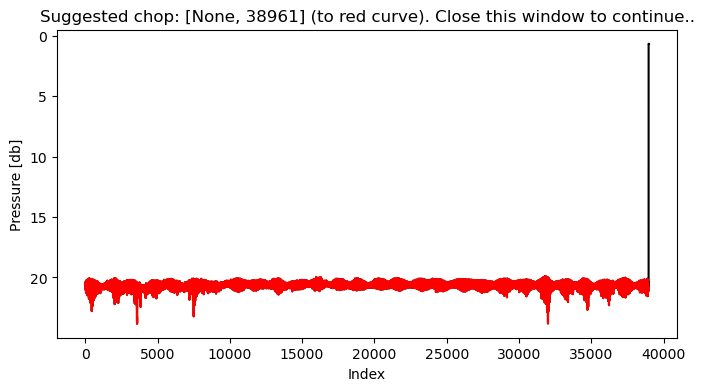

Suggested chop: [None, 38961] (to red curve)
Accept (y/n)?: y
Chopping to index [None, 38961]
Chopped 18 ensembles using -> [None, 38961] (total ensembles 38979 -> 38961)


In [27]:
# Good starting point: Just call the function and follow the prompts. 
DX = sig_load.chop(DX)

We have now chopped away the time on deck durign the recovery, reducing the size of the dataset a bit.

Note that this information is preserved in *DX.history* attribute 

In [28]:
print(DX.history)

- Loaded from .mat files on 08 Jun 2023.
- Chopped 18 ensembles using -> [None, 38961] (total ensembles 38979 -> 38961)


# Draft

We are now ready to calculate the sea ice draft. The basic approach is:

1. Calculate depth of the scattering surface from depth/tilt/sound/speed/altimeter distance.
    - All valid values (open water and ice) are stored as *SURFACE_DEPTH_*
    - Only values during estimated sea ice presence are stored as *SEA_ICE_DRAFT_*
2. Extract a time-varying "open water correction" forcing the long-time moving average open water values to be near zero.
    - Calculate a sound speed correction factor $\beta$ which would make the necessary correction to the open water values.
3. Repeat step 1, but now applying the sound speed $\beta$ to the distance calculation.

##### Step 1: Initial calculation of surface depths


In [29]:
DX = sig_draft.calculate_draft(DX)

We have now added a bunch of new fields to *DX* (e.g. *SURFACE_DEPTH_LE*, *SEA_ICE_DRAFT_AST*..).

Note that We do the calculation - separately - for both the *AST* and *LE* altimeter estimates. 

For the *LE* estimate (which typically is better/less noisy, but detects "false keels" near the transducer), we **drop all LE samples where AST and LE disagree by > 0.5 m**. In this case that means dropping a *lot* of samples (something like 1/3 of the dataset), but the hope is that it gives a better estimate.

##### Step 2: Open water correction
*(Note: this can take a minute or so to run)*

(Describe this here in more detailed later..) 

In [30]:
# GET OPEN WATER SOUND SPEED CORRECTION
DX = sig_draft.get_Beta_from_OWSD(DX)

*Note*: We have **not** made any adjustments to the draft yet - just estimated $\beta$ (added as the *BETA_open_water_corr_* fields). 

We can examine the correction now to see if we are happy with it using teh *compare_OW_correction* funcion:
(This function is bulky and should be made more practical)

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_toolbox.py:162: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad = 3)


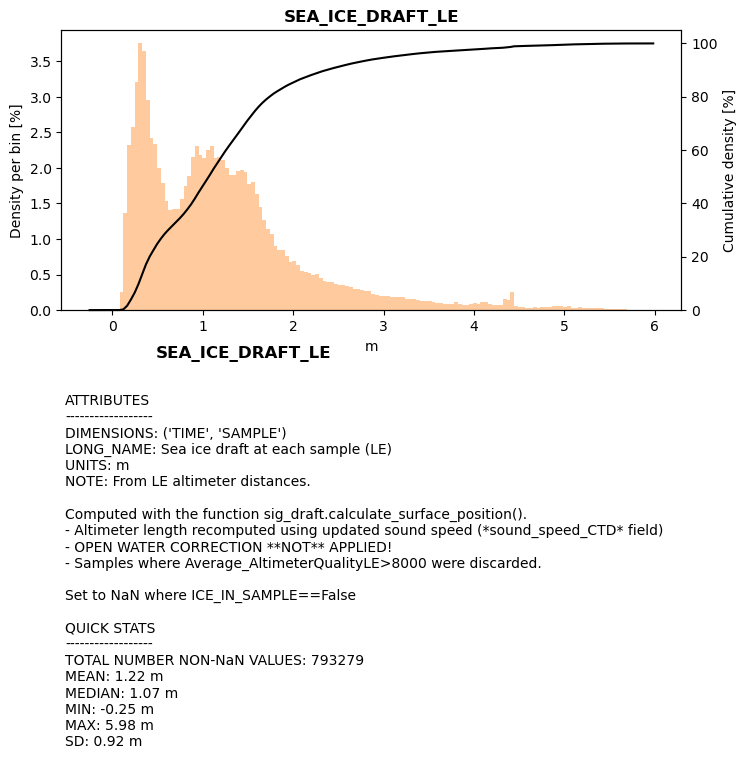

In [31]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_LE', nbins = 150)

LE: Mean (median) offset: 17.2 cm (17.6 cm)
AST: Mean (median) offset: 3.8 cm (3.9 cm)
LE: Mean (median) dBETA: 8.7 (9.0)
AST: Mean (median) dBETA: 1.9 (2.0)
LE - MEAN SEA ICE DRAFT:
Before OW correction: 1.41 m
After OW correction: 1.37 m
AST - MEAN SEA ICE DRAFT:
Before OW correction: 1.15 m
After OW correction: 1.11 m


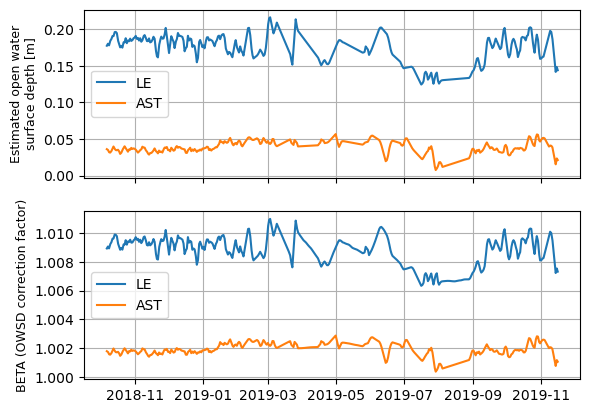

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

In [32]:
# Inspect:
sig_draft.compare_OW_correction(DX)

So we can see that we make a larger adjustment  for LE than (eq to ~18 cm) for AST (eq to ~4 cm).

Will look into this a bit later - but for now we will assume that we are happy with out $beta$, and recompute the draft:

### Recompute draft

In [33]:
DX = sig_draft.calculate_draft(DX)

In [34]:
DX.SEA_ICE_DRAFT_MEDIAN_AST

<xarray.DataArray 'SEA_ICE_DRAFT_MEDIAN_AST' (TIME: 38961)>
array([       nan,        nan,        nan, ..., 0.55329279, 0.3755088 ,
              nan])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    long_name:  Median sea ice draft of each ensemble (AST)
    units:      m
    note:       From AST altimeter distances.\n\nComputed with the function s...

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_toolbox.py:162: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad = 3)


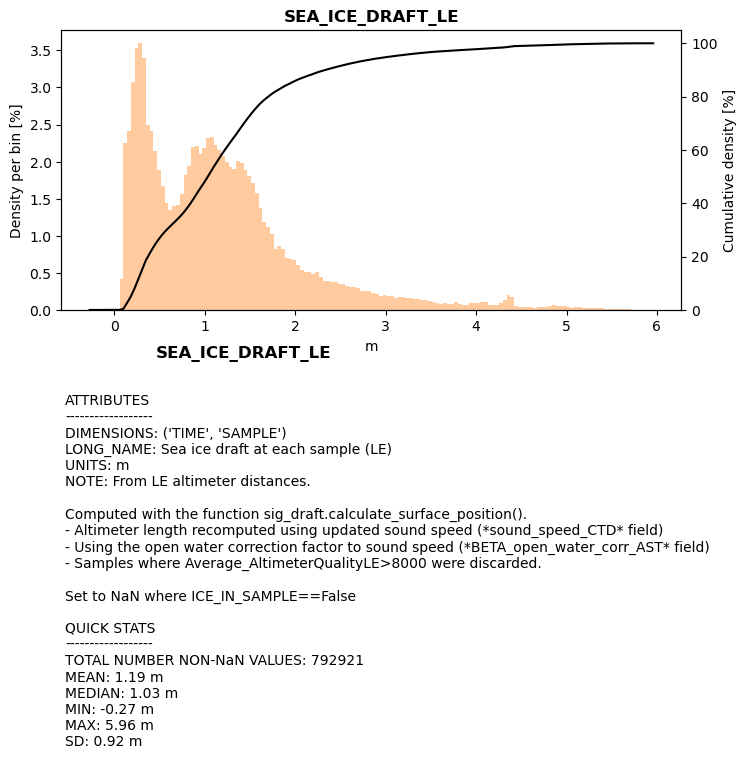

In [35]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_LE', nbins = 150)

We have now updated the calculation to include oue $\beta$,m which should improve the estimate and bring open water values nearer to zero.

if we look at the *SEA_ICE_DRAFT_* and *SURFACE_DEPTH_* fields we should see that this is now specified in the metadata (the *note* field).

##### Quick histogram
We can use the *sig_toolbox.histogram* function for a quick look at the results (also shows the attributes including the *note* field)

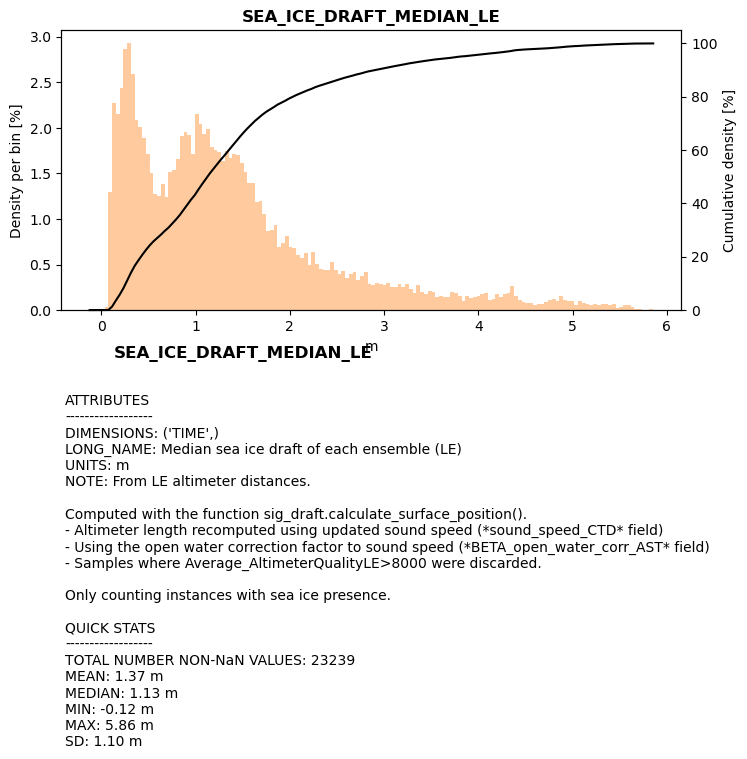

In [36]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_MEDIAN_LE', nbins = 150)

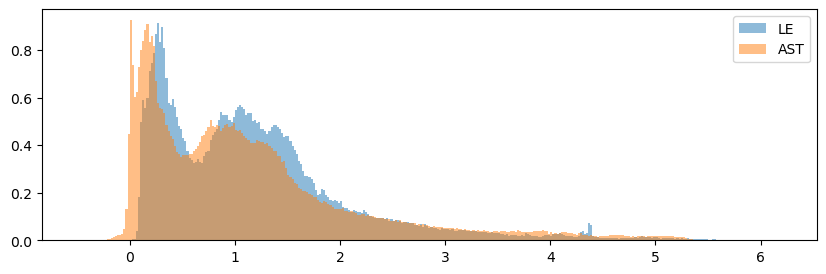

In [37]:
fig, ax = plt.subplots( figsize = (10, 3))
hkws = {'density':True, 'bins':335, 'range':(-0.5, 6.2), 'alpha':0.5}
ax.hist((DX.SEA_ICE_DRAFT_LE).values.flatten(), **hkws, label = 'LE');
ax.hist((DX.SEA_ICE_DRAFT_AST).values.flatten(), **hkws, label = 'AST');
ax.legend()

(-0.2, 0.4)

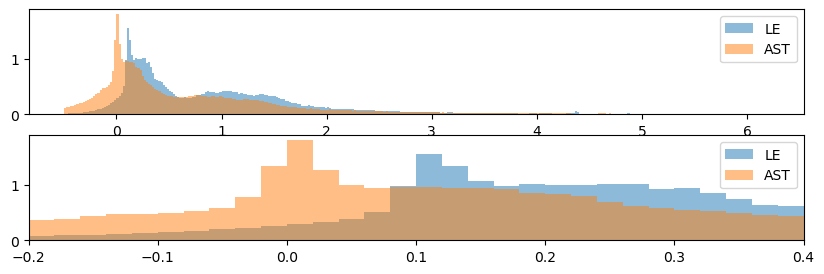

In [38]:
fig, ax = plt.subplots(2, 1,  figsize = (10, 3))
hkws = {'density':True, 'bins':335, 'range':(-0.5, 6.2), 'alpha':0.5}
for axn in ax:
    axn.hist((DX.SURFACE_DEPTH_LE).values.flatten(), **hkws, label = 'LE');
    axn.hist((DX.SURFACE_DEPTH_AST).values.flatten(), **hkws, label = 'AST');
    axn.legend()
ax[1].set_xlim(-0.2, 0.4)

In [39]:
# Compare SD
mean_sd_LE = float(DX.SEA_ICE_DRAFT_LE.std(dim = 'SAMPLE').mean())
mean_sd_AST = float(DX.SEA_ICE_DRAFT_AST.std(dim = 'SAMPLE').mean())
print('Mean SD across samples:')
print('AST: %.2f cm'%(1e2*mean_sd_AST))
print('LE: %.2f cm'%(1e2*mean_sd_LE))

Mean SD across samples:
AST: 23.05 cm
LE: 15.05 cm


/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


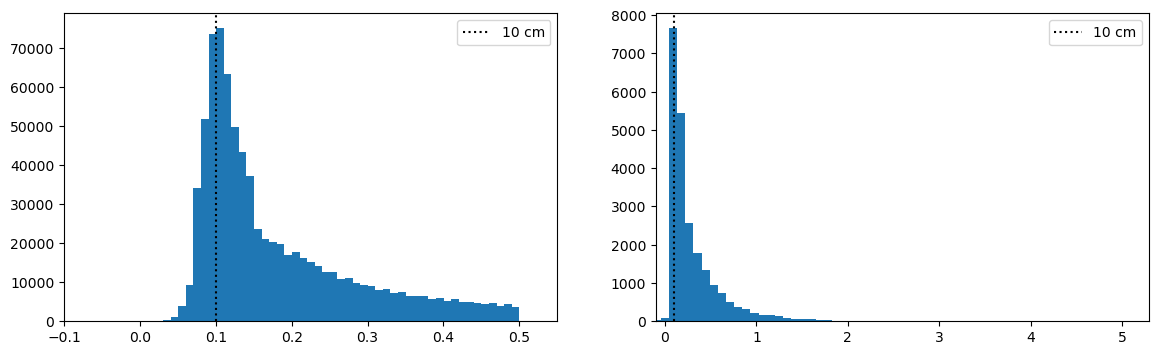

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].hist((DX.SEA_ICE_DRAFT_LE-DX.SEA_ICE_DRAFT_AST).values.flatten(), 100);
ax[1].hist((DX.SEA_ICE_DRAFT_MEDIAN_LE-DX.SEA_ICE_DRAFT_MEDIAN_AST).values, 100);
for axn in ax:
    axn.axvline(0.1, ls = ':', color = 'k', label = '10 cm')
    axn.legend()
    axn.set_xlim(-0.1, None)

**TO DO**

- Continue through with ice velocity. (**X**?)
    - Processing + diagnosis(**X**?)
- Ocean velocity (**X**?)
- Include chopping functions (**X**?)
- Include save to nc functions (**X**?)
- Make static page for git

## Ice velocity

The ice drift velocity calculation is simpler, consisting of:

- Loading the velocities: *uice, vice* from *AverageIce_VelEast/_VelNorth*
- Applying a quality criterion requiring FOM<10 000 for all 4 beams (equivalent to requiring *ICE_IN_SAMPLE==True*)
    - Rejecting all samples where this does not hold 
- Calculate ensemble median values *Uice, Vice* (default is to use medians, can also use means).
   - Also creating *Uice_SC, Vice_SD* - containing the ensemble standard deviation. 
- Rotate the current vectors to account for magnetic declination.
  - Applied to both *uice* and *Uice*. (Also applying to ocean velocities now..)

##### Create the ice uv fields 

In [43]:
import importlib as imp

In [49]:
np.seterr()

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [50]:
np.seterr(all = 'raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [139]:
imp.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [140]:
DX = sig_vel.calculate_ice_vel(DX)

.. we have now added *uice, vice, Uice, Vice, Uice_SD, Vice_SD* to *DX*.

We can compare *uice* with the original *AverageIce_VelEast* field to see what out FOM cleaning has done:

Text(0.1, 0.8, 'ZOOMED')

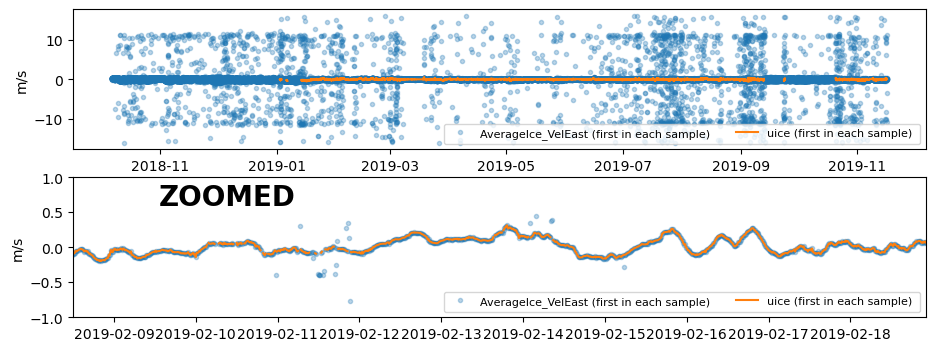

In [143]:
fig, ax = plt.subplots(2, 1, figsize = (11, 4))
for axn in ax:
    axn.plot(DX.TIME, DX.AverageIce_VelEast.isel(SAMPLE=0), '.', alpha = 0.3,label= 'AverageIce_VelEast (first in each sample) ')
    axn.plot_date(DX.TIME, DX.uice.isel(SAMPLE=0), '-', label= 'uice (first in each sample) ')
    axn.set_ylabel('m/s')
    axn.legend(ncol = 2, fontsize = 8, loc = 4)
ax[1].set_xlim(num2date(DX.TIME[12000]), num2date(DX.TIME[13000]))
ax[1].set_ylim(-1, 1)

ax[1].text(0.1, 0.8, 'ZOOMED', fontsize = 20, fontweight = 'bold', transform=ax[1].transAxes)

##### Inspect
The function *sig_toolbox.plot_ellipse_icevel* is useful to get a quick look at the ice velocity data. It shows the u/v spread, mean and low-passed velocity, and the variance ellipse (of the low-passed currents)

In [144]:
importlib.reload(sig_vel)
importlib.reload(sig_toolbox)

<module 'sigpyproc.sig_toolbox' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_toolbox.py'>

In [145]:

    print('ELLIPSE PLOT: Interpolate over nans.. \r', end = '')

    uip = DX.Uice.interpolate_na(dim = 'TIME', limit=10).data
    vip = DX.Vice.interpolate_na(dim = 'TIME', limit=10).data


In [146]:
lp_days =5
print('ELLIPSE PLOT: Low pass filtering..    \r', end = '')
# LPFed 
wlen = int(np.round(lp_days/(DX.sampling_interval_sec/60/60/24)))
ULP = np.convolve(uip, np.ones(wlen)/wlen,
            mode = 'valid')[::wlen]
VLP = np.convolve(vip, np.ones(wlen)/wlen,
            mode = 'valid')[::wlen]


In [147]:
    axn.axvline(0.1, ls = ':', color = 'k')

In [148]:
sig_toolbox.plot_ellipse_icevel(DX);

KeyboardInterrupt: 

--> OK. 

Note that some metadata has been added to the velocity fields, e.g.:

## Ocean velocities 

In [149]:
importlib.reload(sig_load)
importlib.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [150]:
#DX = sig_vel._calculate_bin_depths(DX)
DX = sig_vel.calculate_ocean_vel(DX)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.mean().data], [0, DX.Vocean.mean().data], '-r')

In [ ]:
fig, ax = plt.subplots(2, 1, )
ax[0].pcolormesh(DX.Uocean, vmin = -0.3, vmax =0.3, cmap = 'RdBu')
ax[1].pcolormesh(DX.Vocean, vmin = -0.3, vmax =0.3, cmap = 'RdBu')

In [ ]:
DX = sig_vel.reject_sidelobe(DX)

In [ ]:
DX = sig_vel.clear_empty_bins(DX)

In [ ]:
DX = sig_vel.uvoc_mask_range(DX)

In [ ]:
DX = sig_vel.clear_empty_bins(DX)

In [ ]:
fig, ax = plt.subplots(2, 1, )
ax[0].pcolormesh(DX.Uocean, vmin = -0.2, vmax =0.2, cmap = 'RdBu')
ax[1].pcolormesh(DX.Vocean, vmin = -0.2, vmax =0.2, cmap = 'RdBu')

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.isel(BINS=4).median().data], [0, DX.Vocean.isel(BINS=4).median().data], '-r')
ax.plot([0, DX.Uocean.isel(BINS=4).mean().data], [0, DX.Vocean.isel(BINS=4).mean().data], '-b')

### Rotating for magnetic declination

Earlier, we added the *magdec* field to *DX*. We can now use it to rotate the ice velocity vectors:

In [151]:
DX = sig_vel.rotate_vels_magdec(DX)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(DX.Uocean.isel(BINS=4), DX.Vocean.isel(BINS=4), color = 'k', alpha = 0.07, s = 0.1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot([0, DX.Uocean.isel(BINS=4).median().data], [0, DX.Vocean.isel(BINS=4).median().data], '-r')
ax.plot([0, DX.Uocean.isel(BINS=4).mean().data], [0, DX.Vocean.isel(BINS=4).mean().data], '-b')

In [ ]:
print(DX.Uocean.processing_history)

In [ ]:
DX.Uocean

#### Impose criterion on ocean velocity

##### Trying out some different criteria..

In [ ]:
DX0 = sig_vel._calculate_uvocean_avg(DX.copy())
print(DX.Uocean.std().data)
print(DX.Uocean.attrs['processing_history'][-67:])

In [ ]:
DX1 = sig_vel._calculate_uvocean_avg(DX.copy(), min_good_pct=80).copy()
print(DX1.Uocean.std().data)
print(DX1.Uocean.attrs['processing_history'][-67:])

In [ ]:
DX2 = sig_vel._calculate_uvocean_avg(DX.copy(), min_good_pct=99).copy()
print(DX2.Uocean.std().data)
print(DX2.Uocean.attrs['processing_history'][-67:])

In [ ]:
print(np.sum(np.isnan(DX2.Uocean)).data)
print(np.sum(np.isnan(DX1.Uocean)).data)
print(np.sum(np.isnan(DX.Uocean)).data)

In [ ]:
bin_nr = 4
bin_depth_nr = DX0.bin_depth.mean(dim= 'TIME')[bin_nr]

fig, ax = plt.subplots(
    figsize = (14, 3))
add = 22000
time_slice = slice(4000+add, 9000+add)
subset_time = DX0.TIME.isel(TIME = time_slice)

ax.plot(subset_time, DX0.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'r', lw = 0.8,label = 'No criterion')
#ax.plot(subset_time, DX2.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'b', label = '40% criterion')
ax.plot(subset_time, DX1.Uocean.isel(BINS=bin_nr, TIME = time_slice), 'k', label = '80% criterion')

ax.legend()

ax.set_title('Vocean (bin near %.2f m depth)'%bin_depth_nr)
ax.set_ylabel('m/s')
ax.set_xlim(18090, 18100)

#### Applying to the Umean, Vmean fields

In [152]:
DX = sig_vel._calculate_uvocean_avg(DX, min_good_pct=80)


#### Interpolating velocity

Useful if we want a time series of ocean velocity at a select depth.

(Adds a new field (e.g. *Uocean_10m*) to *DX*)

Added interpolated velocities: (Uocean_10m, Vocean_10m)


Text(0, 0.5, 'm/s')

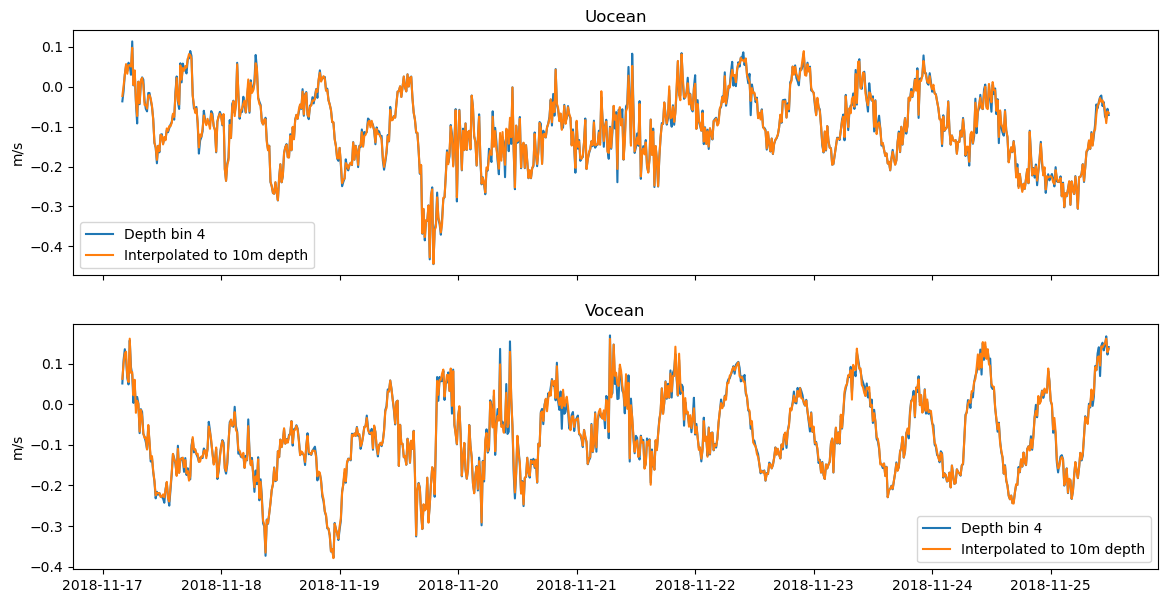

In [153]:

DX = sig_vel.interp_oceanvel(DX, 10)

bin_nr = 4

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (14, 7))
time_slice = slice(4000, 4800)
subset_time = DX.TIME.isel(TIME = time_slice)

ax[0].plot(subset_time, DX.Uocean.isel(BINS=bin_nr, TIME = time_slice), label = 'Depth bin %i'%bin_nr)
ax[0].plot(subset_time, DX.Uocean_10m.isel(TIME = time_slice), label = 'Interpolated to 10m depth')
ax[0].legend()

ax[1].plot(subset_time, DX.Vocean.isel(BINS=bin_nr, TIME = time_slice), label = 'Depth bin %i'%bin_nr)
ax[1].plot_date(subset_time, DX.Vocean_10m.isel(TIME = time_slice), '-', label = 'Interpolated to 10m depth')
ax[1].legend()
ax[0].set_title('Uocean')
ax[1].set_title('Vocean')
ax[0].set_ylabel('m/s')
ax[1].set_ylabel('m/s')

#ax[0].set_xlim(4000, 4800)

In [154]:
DX.Uocean_10m

<xarray.DataArray 'Uocean_10m' (TIME: 38961)>
array([-0.1243452 , -0.07424972, -0.11828019, ..., -0.22327972,
       -0.21092053, -0.18450019])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
Attributes:
    units:               m s-1
    long_name:           Eastward ocean velocity interpolated to 10.0 m depth
    details:             Ensemble average (median)
    processing_history:  Loaded from Average_VelEast/Average_VelEast fields.\...

## Exporting

In [155]:
sig_load.overview(DX)


TIME RANGE:
06 Oct 2018 12:00  -->  16 Nov 2019 08:00  (405.8 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure: 20.6 dbar (0.3 dbar)  - with fixed atm offset 9.500 dbar.

SIZE:
Total 1870128 time points.
Split into 38961 ensembles with 48 sample per ensemble.
Ocean velocity bins: 16.


In [ ]:
sig_load.to_nc(DX, 'testfile.nc', export_vars= ['SIC_FOM'], icedraft = True, icevel = True, oceanvel = False)

#### Read the testfile..

In [ ]:
TF = xr.open_dataset('testfile.nc')

In [ ]:
TF.attrs.conf

In [ ]:
TF.close()

In [ ]:
print(DX.instrument_configuration_details)

## Look at raw file

In [ ]:
fn_ = flist[3]#14 has weird temp
dx = sig_load._matfile_to_dataset(fn_, include_raw_altimeter=True)[0]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (14, 6))
ax[0].plot(dx.Average_AltimeterDistanceLE, '.', ms=1, alpha = 0.05)
ax[1].plot(dx.Average_AltimeterQualityLE, '.', ms=1, alpha = 0.05)
ax[0].set_ylim(18, 21)

In [ ]:
1,450 and 1,570

In [ ]:
fig,ax = plt.subplots(3, 1, figsize = (8, 12))
ax[0].plot(dx.Average_Soundspeed, label='Average_Soundspeed')

twinax = ax[0].twiny()
twinax.plot(dx.AverageRawAltimeter_Soundspeed, 'r', label = 'AverageRawAltimeter_Soundspeed')

ax[1].plot(dx.Average_Temperature, label='Average_Temperature')
ax[1].plot(dx.Average_PressureSensorTemperature, label='Average_PressureSensorTemperature')
ax[1].plot(dx.Average_RTCTemperature, label='Average_RTCTemperature')

twinax2 = ax[1].twiny()
twinax2.plot(dx.AverageRawAltimeter_Temperature, 'r', label='AverageRawAltimeter_Temperature')
#ax[1].plot(DX.AverageRawAltimeter_Soundspeed.mean('SAMPLE'), label='Average_PressureSensorTemperature')


ax[2].plot(dx.Average_AltimeterDistanceLE, '.', alpha = 0.1, label='Average_AltimeterDistanceLE')

twinax3 = ax[2].twiny()
twinax3.plot(dx.AverageRawAltimeter_AltimeterDistanceLE, 'r', label='AverageRawAltimeter_AltimeterDistanceLE')

ax[0].set_title('Sound speeds')
ax[1].set_title('Temperatures')
ax[2].set_title('LE distances')


plt.tight_layout()

ax[0].legend(bbox_to_anchor = (1.5, 1))
twinax.legend(bbox_to_anchor = (1.7, 0.4))
ax[1].legend(bbox_to_anchor = (1.7, 1))
twinax2.legend(bbox_to_anchor = (1.7, 0))
ax[2].legend(bbox_to_anchor = (1.5, 1))
twinax3.legend(bbox_to_anchor = (1.7, 0.5))
ax[1].axhline(-2, color = 'k', ls = ':')
#ax.set_ylim(25, 18)

### Questions for me
- Which temperature matches the RBRs best?


### Questions for Nortek

- Are they *sure* that 0.5+0.24*x is the correct formula?
- IF NOT: Why don't these line up better? (the difference is dramatic - around a meter!)
- **DO I NEED TO APPLY A CORRECTION FACTOR TO ANYTHING HERE?**
- **HOW ARE THESE THINGS ACTUALLY CALCULATED? WHAT SOUND SPEEDS GO WHERE?**

*Note: This is before the pressure does anything, so is can probably only be altimeter and/or sound speed*

- *(Is this with a "raw/nominal" sound speed?)*

Confirm that I am reading the right fields:
- *Average_AltimeterDistanceAST/Average_AltimeterDistanceLE*
- *Average_VelNorth*..
- *Average_VelEast*..

Other:
- What are the *AltimeterQuality* parameters ? Seem a bit arbitrary.

In [ ]:
dx.Average_AltimeterDistanceAST